Hello world 1
Hello world 2


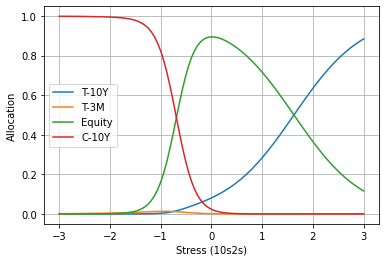

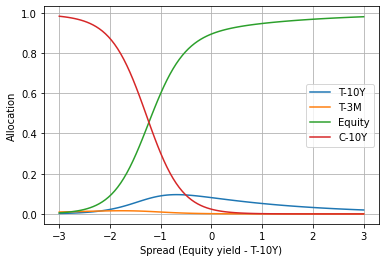

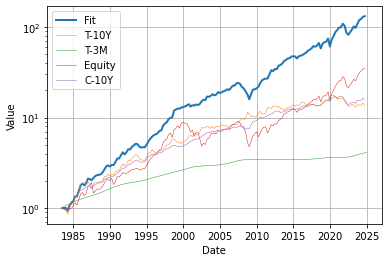

In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

#### Load data
dir = ''

# treasuries
df = pd.read_csv(dir + 'us3month.txt')
df = df.merge(pd.read_csv(dir + 'us2year.txt'), on='Date')
df = df.merge(pd.read_csv(dir + 'us10year.txt'), on='Date')
df = df[1:][::-1].reset_index(drop=True)

# actual rates (assuming quarterly roll)
df['3M_ACT'] = 1 + df['3M'] / 100

p2_buy = 1 / (1 + df['2Y'] / 100)**2
p2_sell = 1 / (1 + df['2Y'][1:] / 100)**(2 - .25)
df['2Y_ACT'] = (p2_sell.values / p2_buy[:-1]) ** 4

p10_buy = 1 / (1 + df['10Y'] / 100)**10
p10_sell = 1 / (1 + df['10Y'][1:] / 100)**(10 - .25)  # assuming 9.75Y and 10Y yields are the same
df['10Y_ACT'] = (p10_sell.values / p10_buy[:-1]) ** 4

# equity
df = df.merge(pd.read_csv(dir + 'sp500price.txt'), on='Date')
df = df.merge(pd.read_csv(dir + 'sp500ape.txt'), on='Date')
df['FWD_EQUITY'] = (df['SP500'][1:].values / df['SP500'][:-1])**4

# ~10Y corp bond index (corporate index us invest grade)
df = df.merge(pd.read_csv(dir + 'corp10year.txt'), on='Date')
df['CORP_ACT'] = (df['CORP10'].values[1:] / df['CORP10'][:-1]) ** 4

#### Init data handling
years = 1
M = 4*years # length of optimization period (in quarters)
spread = (100/df['APE'] - df['10Y']).values  # spread between proxy equity yield and 10Y T yield
stress = (df['10Y'] - df['2Y']).values  # 10s2s stress indicator

def softmax(m):
    _me = np.exp(m) / np.nansum(np.exp(m), axis=0)
    return _me

def allocation(theta, stress, spread):
    assert len(stress) == len(spread)
    key = np.repeat(theta[:4], len(stress)).reshape(-1, len(stress)) + \
          np.array([theta[4:8]]).T @ np.array([stress]) + \
          np.array([theta[8:12]]).T @ np.array([spread])
          # np.array([theta[12:16]]).T @ (np.array([stress])**2) + \
          # np.array([theta[16:20]]).T @ (np.array([spread])**2)
    key = softmax(key).T
    return key

def rates_act(alloc):
    return alloc[:, 0] * df['10Y_ACT'] + alloc[:, 1] * df['3M_ACT'] + alloc[:, 2] * df['FWD_EQUITY'] + alloc[:, 3] * \
            df['CORP_ACT']

def loss_func(theta):
    alloc = allocation(theta, stress, spread)
    rates = rates_act(alloc)
    sol = [np.prod(rates[i:(i+M)]**(1/4)) for i in range(len(rates)-M)]
    # q = [np.quantile(sol, .25)]  # VaR
    q = [np.quantile(sol, q) for q in np.linspace(0.5, 0.1, 20)] # CVaR
    x = np.mean(q)
    return -x

#### Investigate result
sol = minimize(loss_func, x0=np.ones(12), method='Nelder-Mead')
alloc = allocation(sol.x, stress, spread)
np.prod(rates_act(alloc)) ** (1/len(alloc))  # ave return

# vary stress
N = 100
x = np.linspace(-3, 3, N)
y = np.ones(N) * 0
_alloc = allocation(sol.x, x, y)
plt.plot(x, _alloc[:, 0])
plt.plot(x, _alloc[:, 1])
plt.plot(x, _alloc[:, 2])
plt.plot(x, _alloc[:, 3])
plt.legend(['T-10Y', 'T-3M', 'Equity', 'C-10Y'])
plt.xlabel('Stress (10s2s)')
plt.ylabel('Allocation')
plt.grid()
plt.show()

# vary spread
N = 100
x = np.ones(N) * 0
y = np.linspace(-3, 3, N)
_alloc = allocation(sol.x, x, y)
plt.plot(y, _alloc[:, 0])
plt.plot(y, _alloc[:, 1])
plt.plot(y, _alloc[:, 2])
plt.plot(y, _alloc[:, 3])
plt.legend(['T-10Y', 'T-3M', 'Equity', 'C-10Y'])
plt.xlabel('Spread (Equity yield - T-10Y)')
plt.ylabel('Allocation')
plt.grid()
plt.show()


#### Compare scenarios
alloc = allocation(sol.x, stress, spread)
rates_optim = rates_act(alloc)
x = pd.to_datetime(df['Date'])
plt.semilogy(x, np.cumprod(rates_optim**(1/4)), linewidth=2)
plt.semilogy(x, np.cumprod(df['10Y_ACT']**(1/4)),  linewidth=.5)
plt.semilogy(x, np.cumprod(df['3M_ACT']**(1/4)),  linewidth=.5)
plt.semilogy(x, np.cumprod(df['FWD_EQUITY']**(1/4)),  linewidth=.5)
plt.semilogy(x, np.cumprod(df['CORP_ACT']**(1/4)),  linewidth=.5)
plt.legend(['Fit', 'T-10Y', 'T-3M', 'Equity', 'C-10Y'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.show()



In [ ]:
import pandas
import os

In [ ]:
os.listdir()